In [1]:
import pandas as pd
import numpy as np
import pickle 

# Loading Inputs

In [2]:
# for some weird reason required in Jupyter Lab when unpickling model, scaler
import sys
sys.path.append('..')

In [3]:
model = pickle.load(open('../data/06_models/model.pkl/2020-10-09T15.53.34.176Z/model.pkl', 'rb'))
model['pass 1']

In [4]:
model

{'pass 1': <src.utils.modeling.ForecastingModel at 0x7fc404184670>,
 'pass 2': <src.utils.modeling.ForecastingModel at 0x7fc3c4faa820>,
 'pass 3': <src.utils.modeling.ForecastingModel at 0x7fc3c4fb8910>,
 'full': <src.utils.modeling.ForecastingModel at 0x7fc3c4fc7a00>}

In [5]:
model['full'].submodels_

{'DEF0C': <statsmodels.tsa.holtwinters.HoltWintersResultsWrapper at 0x7fc3c4fc7a30>,
 'DE111': <statsmodels.tsa.holtwinters.HoltWintersResultsWrapper at 0x7fc3c4fcca90>}

In [6]:
modeling = {
    'targets': ['DEF0C', 'DE111']
}

In [7]:
cv_splits_positions = pickle.load(open('../data/05_model_input/splits_positions.pkl/2020-10-08T15.33.52.010Z/splits_positions.pkl', 'rb'))
cv_splits_positions

{'pass 1': {'train': slice(0, 542, None), 'val': slice(542, 549, None)},
 'pass 2': {'train': slice(0, 719, None), 'val': slice(719, 726, None)},
 'pass 3': {'train': slice(0, 896, None), 'val': slice(896, 903, None)}}

In [8]:
df_infer = capacity_factors_daily_2000to2015 = pd.read_hdf(
    path_or_buf='../data/05_model_input/df_infer.hdf', 
    key='df_infer'
)

df_test = capacity_factors_daily_2000to2015 = pd.read_hdf(
    path_or_buf='../data/05_model_input/df_test.hdf', 
    key='df_test'
)

display(df_infer.head(3), df_infer.shape, df_test.head(3), df_test.shape)

,DE145,DE114,DE146,DE132,DE12A,DE133,DE12C,DE11C,DE118,DE119,...,DEG01,DEG0F,DE275,DE21C,DE234,DE251,DE276,DE278,DE718,DE943
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.219507,0.269458,0.240540,0.263019,0.593148,0.331149,0.555176,0.284140,0.357407,0.410291,...,0.300818,0.363388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.083655,0.063571,0.043303,0.005984,0.080731,0.007986,0.066120,0.083709,0.078740,0.108224,...,0.150699,0.133930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,0.246707,0.229298,0.337413,0.047907,0.279092,0.136004,0.237430,0.320095,0.460150,0.516133,...,0.348737,0.297686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(903, 292)

,DE145,DE114,DE146,DE132,DE12A,DE133,DE12C,DE11C,DE118,DE119,...,DEG01,DEG0F,DE275,DE21C,DE234,DE251,DE276,DE278,DE718,DE943
date,,,,,,,,,,,,,,,,,,,,,
2015-06-23,0.366372,0.282144,0.169123,0.102384,0.299887,0.085913,0.264382,0.337191,0.124571,0.252602,...,0.134666,0.162422,0.573021,0.416591,0.663477,0.429502,0.499571,0.522793,0.507254,0.238118
2015-06-24,0.011242,0.008288,0.012873,0.006662,0.006408,0.011105,0.008853,0.012184,0.006574,0.024096,...,0.068389,0.070911,0.063352,0.037593,0.179141,0.085772,0.045303,0.043444,0.097510,0.248150
2015-06-25,0.007218,0.007427,0.004105,0.006482,0.011570,0.007547,0.008719,0.007859,0.003046,0.003604,...,0.002606,0.002760,0.002339,0.003077,0.007730,0.002873,0.003176,0.003211,0.021591,0.055783


(7, 292)

In [9]:
import sys
sys.path.append('..')
scaler = pickle.load(open('../data/05_model_input/scaler.pkl/2020-10-09T15.53.34.176Z/scaler.pkl', 'rb'))
scaler

Scaler(steps=[('quantiletransformer',
               QuantileTransformer(output_distribution='normal',
                                   random_state=0)),
              ('makestrictlypositive', MakeStrictlyPositive())])

# Making Predictions

In [10]:
targets = modeling['targets']

In [11]:
preds = {}
for pass_id in cv_splits_positions.keys():
    preds[pass_id] = {}
    for cat in ['train', 'val']:
        yhat = {}
        
        window = df_infer[ cv_splits_positions[pass_id][cat]].index
        start = window[0]
        end = window[-1]

        preds[pass_id][cat] = model[pass_id].predict(start, end, scaler) 
        
# model trained on entire inference dataset
preds['full'] = {}

for cat in ['train', 'test']:
    
    if cat == 'train':
        df = df_infer
    else: 
        df = df_test
        
    start = df.index[0]
    end = df.index[-1]
        
    preds['full'][cat] = model['full'].predict(start, end, scaler) 

In [12]:
preds['full']['test']

,DEF0C,DE111
2015-06-23,0.102816,0.063786
2015-06-24,0.098686,0.066355
2015-06-25,0.099991,0.058471
2015-06-26,0.110583,0.059606
2015-06-27,0.113829,0.067134
2015-06-28,0.131787,0.071151
2015-06-29,0.119016,0.060346


In [41]:
gtruth = {}
preds = {}
targets = model['full'].modeling['targets']
for pass_id in cv_splits_positions.keys():
    gtruth[pass_id] = {}
    preds[pass_id] = {}
    for cat in ['train', 'val']:
        y = {}
        yhat = {}
        
        window = df_infer[ cv_splits_positions[pass_id][cat]].index
        start = window[0]
        end = window[-1]
        
        gtruth[pass_id][cat] = df_infer[slice(start, end)][targets]
        preds[pass_id][cat] = model[pass_id].predict(start, end, scaler) 
        
# model trained on entire inference dataset
gtruth['full'] = {}
preds['full'] = {}

for cat in ['train', 'test']:
    
    if cat == 'train':
        df = df_infer
    else: 
        df = df_test
        
    start = df.index[0]
    end = df.index[-1]
    
    gtruth['full'][cat] = df[slice(start, end)][targets]
    preds['full'][cat] = model['full'].predict(start, end, scaler) 

In [43]:
gtruth['pass 3']['val']

,DEF0C,DE111
date,,
2015-06-16,0.145396,0.046773
2015-06-17,0.338567,0.013631
2015-06-18,0.355809,0.083842
2015-06-19,0.370678,0.063776
2015-06-20,0.218804,0.031796
2015-06-21,0.048347,0.031256
2015-06-22,0.076476,0.092497


In [15]:
preds['full'][cat]

,DEF0C,DE111
2015-06-23,0.102816,0.063786
2015-06-24,0.098686,0.066355
2015-06-25,0.099991,0.058471
2015-06-26,0.110583,0.059606
2015-06-27,0.113829,0.067134
2015-06-28,0.131787,0.071151
2015-06-29,0.119016,0.060346


# Evaluating

In [19]:
from sklearn.metrics import mean_squared_error , mean_absolute_error 
from src.utils.metrics import mean_absolute_percentage_error 

In [77]:
metrics_dict = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'MAPE': mean_absolute_percentage_error
}

In [71]:
scores_nodewise = pd.DataFrame(
    data=None,
    index=pd.MultiIndex.from_product([['MAE', 'MSE', 'MAPE'], ['train', 'val', 'test']]),
    columns=model.keys()
)

scores_nodewise

pass 1 pass 2 pass 3 full
MAE  train    NaN    NaN    NaN  NaN
     val      NaN    NaN    NaN  NaN
     test     NaN    NaN    NaN  NaN
MSE  train    NaN    NaN    NaN  NaN
     val      NaN    NaN    NaN  NaN
     test     NaN    NaN    NaN  NaN
MAPE train    NaN    NaN    NaN  NaN
     val      NaN    NaN    NaN  NaN
     test     NaN    NaN    NaN  NaN

In [78]:
for pass_id in list(model.keys()) + ['full']:
    for cat in ['train', 'val', 'test']:
        for metric in ['MSE', 'MAE', 'MAPE']:
            try: 
                scores_nodewise.loc[(metric, cat), pass_id] = metrics_dict[metric](
                        gtruth[pass_id][cat], 
                        preds[pass_id][cat], 
                )
            except:
                pass

In [79]:
scores_nodewise

pass 1     pass 2     pass 3        full
MAE  train   0.0916663  0.0879753  0.0915085   0.0913561
     val     0.0511044    0.19218  0.0840401         NaN
     test          NaN        NaN        NaN   0.0662942
MSE  train   0.0207661  0.0191716  0.0206352   0.0205581
     val    0.00525126  0.0560275  0.0134748         NaN
     test          NaN        NaN        NaN  0.00719795
MAPE train     1.71784    1.66691    1.72657     1.71875
     val      0.795219    1.62158   0.696952         NaN
     test          NaN        NaN        NaN     4.44366

In [83]:
scores_nodewise = pd.DataFrame(
    data=None,
    index=pd.MultiIndex.from_product([['MAE', 'MSE', 'MAPE'], ['train', 'val', 'test']]),
    columns=model.keys()
)

for pass_id in list(model.keys()) + ['full']:
    for cat in ['train', 'val', 'test']:
        for metric in ['MSE', 'MAE', 'MAPE']:
            try: 
                scores_nodewise.loc[(metric, cat), pass_id] = metrics_dict[metric](
                        gtruth[pass_id][cat], 
                        preds[pass_id][cat], 
                        multioutput='raw_values',
                )
            except:
                pass
            
scores_nodewise

pass 1  \
MAE  train     [0.1437736430185535, 0.03955900016243318]   
     val      [0.0644370569813407, 0.037771802359072994]   
     test                                            NaN   
MSE  train  [0.036973246694859775, 0.004558892487990085]   
     val     [0.006441298819987512, 0.00406122408786384]   
     test                                            NaN   
MAPE train      [1.5307812592735606, 1.9049076492870118]   
     val        [0.9903190187774867, 0.6001194014679373]   
     test                                            NaN   

                                                  pass 2  \
MAE  train     [0.1379771388566639, 0.03797340957266288]   
     val      [0.24562027385472354, 0.13874040037011598]   
     test                                            NaN   
MSE  train  [0.033951450972455124, 0.004391653030994339]   
     val     [0.08980681417447443, 0.022248176981407377]   
     test                                            NaN   
MAPE train       [1.513686990992759, 1.8201314386256846]   
     val        [1.2738576400720636, 1.9692987085013072]   
     test                                            NaN   

                                                   pass 3  \
MAE  train     [0.14214655675348936, 0.04087038947521112]   
     val       [0.1373587701824562, 0.030721348987606978]   
     test                                             NaN   
MSE  train   [0.03595801716335215, 0.0053124820918753965]   
     val    [0.025382733803204018, 0.0015669154094353356]   
     test                                             NaN   
MAPE train       [1.4775339877207174, 1.9756031556216291]   
     val         [0.8504198997817933, 0.5434841846453117]   
     test                                             NaN   

                                                    full  
MAE  train    [0.14188148465761918, 0.04083074098593054]  
     val                                             NaN  
     test     [0.07743658145846874, 0.05515177748755808]  
MSE  train   [0.03581889665806032, 0.005297373710068971]  
     val                                             NaN  
     test   [0.011112820926175595, 0.003283079417102682]  
MAPE train       [1.4705598604607863, 1.966932747584853]  
     val                                             NaN  
     test        [1.6722392887044855, 7.215087997161411]

In [88]:
preds.keys()

dict_keys(['pass 1', 'pass 2', 'pass 3', 'full'])

In [82]:
scores = pd.DataFrame(
    data=None,
    index=pd.MultiIndex.from_product([['MAE', 'MSE', 'MAPE'], ['train', 'val', 'test']]),
    columns=model.keys()
)

for pass_id in list(model.keys()) + ['full']:
    for cat in ['train', 'val', 'test']:
        for metric in ['MSE', 'MAE', 'MAPE']:
            try: 
                scores.loc[(metric, cat), pass_id] = metrics_dict[metric](
                        gtruth[pass_id][cat], 
                        preds[pass_id][cat], 
                )
            except:
                pass
            
scores

pass 1     pass 2     pass 3        full
MAE  train   0.0916663  0.0879753  0.0915085   0.0913561
     val     0.0511044    0.19218  0.0840401         NaN
     test          NaN        NaN        NaN   0.0662942
MSE  train   0.0207661  0.0191716  0.0206352   0.0205581
     val    0.00525126  0.0560275  0.0134748         NaN
     test          NaN        NaN        NaN  0.00719795
MAPE train     1.71784    1.66691    1.72657     1.71875
     val      0.795219    1.62158   0.696952         NaN
     test          NaN        NaN        NaN     4.44366

## TODO: there is probably a better way to populate the df based on index, columns (sth. as map(), np.meshgrid )

In [ ]:
import random
def function(data):
    x = random.randrange(0,5)
    return x

In [ ]:
list(map(function, scores_nodewise))

In [ ]:
mmm, ccc, ppp = np.meshgrid(['MAE', 'RMSE', 'MAPE'], ['train', 'val', 'test'], all_passes)

## Testing

In [130]:
scores = pickle.load(open('../data/08_reporting/scores_averaged.pkl/2020-10-09T19.04.10.333Z/scores_averaged.pkl', 'rb'))
scores

pass 1    pass 2    pass 3       full
MAE  train   0.138503  0.132659  0.137568   0.137285
     val    0.0545778  0.271066  0.125084        NaN
     test         NaN       NaN       NaN  0.0905604
RMSE train     0.1867  0.179333  0.184797   0.184436
     val    0.0733428  0.337122  0.145561        NaN
     test         NaN       NaN       NaN   0.115848
MAPE train    140.571    136.27   137.858    137.339
     val      61.1671   173.711   73.6667        NaN
     test         NaN       NaN       NaN    181.134

In [103]:
scores_nodewise = pickle.load(open('../data/08_reporting/scores_nodewise.pkl', 'rb'))
scores_nodewise

pass 1  \
MAE  train   [0.1437736430185535, 0.03955900016243318]   
     val    [0.0644370569813407, 0.037771802359072994]   
     test                                          NaN   
RMSE train                                         NaN   
     val                                           NaN   
     test                                          NaN   
MAPE train    [153.07812592735607, 190.49076492870117]   
     val        [99.03190187774867, 60.01194014679372]   
     test                                          NaN   

                                                pass 2  \
MAE  train   [0.1379771388566639, 0.03797340957266288]   
     val    [0.24562027385472354, 0.13874040037011598]   
     test                                          NaN   
RMSE train                                         NaN   
     val                                           NaN   
     test                                          NaN   
MAPE train     [151.3686990992759, 182.01314386256846]   
     val      [127.38576400720635, 196.92987085013073]   
     test                                          NaN   

                                                pass 3  \
MAE  train  [0.14214655675348936, 0.04087038947521112]   
     val    [0.1373587701824562, 0.030721348987606978]   
     test                                          NaN   
RMSE train                                         NaN   
     val                                           NaN   
     test                                          NaN   
MAPE train    [147.75339877207173, 197.56031556216294]   
     val        [85.04198997817933, 54.34841846453116]   
     test                                          NaN   

                                                  full  
MAE  train  [0.14188148465761918, 0.04083074098593054]  
     val                                           NaN  
     test   [0.07743658145846874, 0.05515177748755808]  
RMSE train                                         NaN  
     val                                           NaN  
     test                                          NaN  
MAPE train    [147.05598604607863, 196.69327475848527]  
     val                                           NaN  
     test      [167.22392887044853, 721.5087997161411]

# Testing

In [105]:
import yaml

In [ ]:
with open(r'../conf/base/parameters.yml') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
    
modeling = params['modeling']

In [109]:
df_infer = capacity_factors_daily_2000to2015 = pd.read_hdf(
    path_or_buf='../data/05_model_input/df_infer.hdf', 
    key='df_infer'
)

df_test = capacity_factors_daily_2000to2015 = pd.read_hdf(
    path_or_buf='../data/05_model_input/df_test.hdf', 
    key='df_test'
)

display(df_infer.head(3), df_infer.shape, df_test.head(3), df_test.shape)

,DE145,DE114,DE146,DE132,DE12A,DE133,DE12C,DE11C,DE118,DE119,...,DEG01,DEG0F,DE275,DE21C,DE234,DE251,DE276,DE278,DE718,DE943
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.219507,0.269458,0.240540,0.263019,0.593148,0.331149,0.555176,0.284140,0.357407,0.410291,...,0.300818,0.363388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.083655,0.063571,0.043303,0.005984,0.080731,0.007986,0.066120,0.083709,0.078740,0.108224,...,0.150699,0.133930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,0.246707,0.229298,0.337413,0.047907,0.279092,0.136004,0.237430,0.320095,0.460150,0.516133,...,0.348737,0.297686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(903, 292)

,DE145,DE114,DE146,DE132,DE12A,DE133,DE12C,DE11C,DE118,DE119,...,DEG01,DEG0F,DE275,DE21C,DE234,DE251,DE276,DE278,DE718,DE943
date,,,,,,,,,,,,,,,,,,,,,
2015-06-23,0.366372,0.282144,0.169123,0.102384,0.299887,0.085913,0.264382,0.337191,0.124571,0.252602,...,0.134666,0.162422,0.573021,0.416591,0.663477,0.429502,0.499571,0.522793,0.507254,0.238118
2015-06-24,0.011242,0.008288,0.012873,0.006662,0.006408,0.011105,0.008853,0.012184,0.006574,0.024096,...,0.068389,0.070911,0.063352,0.037593,0.179141,0.085772,0.045303,0.043444,0.097510,0.248150
2015-06-25,0.007218,0.007427,0.004105,0.006482,0.011570,0.007547,0.008719,0.007859,0.003046,0.003604,...,0.002606,0.002760,0.002339,0.003077,0.007730,0.002873,0.003176,0.003211,0.021591,0.055783


(7, 292)

In [110]:
model = pickle.load(open('../data/06_models/model.pkl/2020-10-09T15.53.34.176Z/model.pkl', 'rb'))
cv_splits_positions = pickle.load(open('../data/05_model_input/cv_splits_positions.pkl/2020-10-09T15.53.34.176Z/cv_splits_positions.pkl', 'rb'))

In [111]:
scaler = pickle.load(open('../data/05_model_input/scaler.pkl/2020-10-09T15.53.34.176Z/scaler.pkl', 'rb'))

In [112]:
def _get_predictions_e_gtruth(model, cv_splits_positions, df_infer, df_test, scaler):
    gtruth = {}
    preds = {}
    targets = model['full'].modeling['targets']
    for pass_id in cv_splits_positions.keys():
        gtruth[pass_id] = {}
        preds[pass_id] = {}
        for cat in ['train', 'val']:

            window = df_infer[cv_splits_positions[pass_id][cat]].index
            start = window[0]
            end = window[-1]

            gtruth[pass_id][cat] = df_infer[slice(start, end)][targets]
            preds[pass_id][cat] = model[pass_id].predict(start, end, scaler)

    # predictions for model trained on entire inference dataset
    gtruth['full'] = {}
    preds['full'] = {}

    for cat in ['train', 'test']:

        if cat == 'train':
            df = df_infer
        else:
            df = df_test

        start = df.index[0]
        end = df.index[-1]

        gtruth['full'][cat] = df[slice(start, end)][targets]
        preds['full'][cat] = model['full'].predict(start, end, scaler)

    return gtruth, preds

In [114]:
gtruth, preds = _get_predictions_e_gtruth(model, cv_splits_positions, df_infer, df_test, scaler)

In [115]:
gtruth['full']['train']

,DEF0C,DE111
date,,
2013-01-01,0.298824,0.178783
2013-01-02,0.277085,0.030363
2013-01-03,0.561925,0.041567
2013-01-04,0.603515,0.128148
2013-01-05,0.139887,0.126854
...,...,...
2015-06-18,0.355809,0.083842
2015-06-19,0.370678,0.063776
2015-06-20,0.218804,0.031796


In [116]:
preds['full']['train']

,DEF0C,DE111
date,,
2013-01-01,0.314448,0.098570
2013-01-02,0.299405,0.152936
2013-01-03,0.294443,0.050359
2013-01-04,0.416653,0.046431
2013-01-05,0.489341,0.093469
...,...,...
2015-06-18,0.207454,0.017798
2015-06-19,0.294201,0.049126
2015-06-20,0.329595,0.063864


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

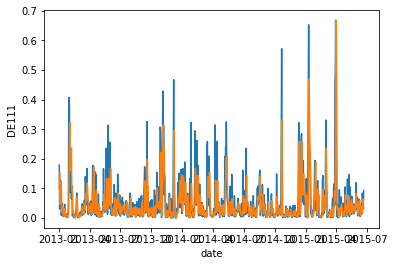

In [126]:
sns.lineplot(x=gtruth['full']['train'].index, y=gtruth['full']['train']['DE111'])
sns.lineplot(x=preds['full']['train'].index, y=preds['full']['train']['DE111'])
plt.show()

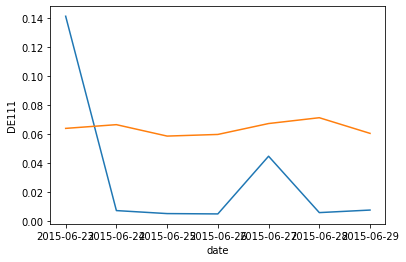

In [129]:
sns.lineplot(x=gtruth['full']['test'].index, y=gtruth['full']['test']['DE111'])
sns.lineplot(x=preds['full']['test'].index, y=preds['full']['test']['DE111'])
plt.show()